<a href="https://colab.research.google.com/github/Yong-Hui-Liew/PyTorch-Adventure/blob/main/04_pytorch_exercise_solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Our models are underperforming (not fitting the data well). What are 3 methods for preventing underfitting? Write them down and explain each with a sentence.

1. Train on more data
2. Increase hidden units/layers
3. Train longer

## 2. Recreate the data loading functions we built in sections 1, 2, 3 and 4. You should have train and test DataLoader's ready to use.

In [109]:
import requests
from pathlib import Path
import zipfile

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
  print(f"path exists, skipping download...")
else:
  print(f"path doesn't exist, creating...")
  image_path.mkdir(parents=True, exist_ok=True)

with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/Yong-Hui-Liew/PyTorch-Adventure/raw/main/pizza_steak_sushi.zip")
  f.write(request.content)

# unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unzipping pizza, steak and sushi data...")
  zip_ref.extractall(image_path)

path exists, skipping download...
Unzipping pizza, steak and sushi data...


In [110]:
import random
from PIL import Image
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir

PosixPath('data/pizza_steak_sushi/train')

In [131]:
image_path_list = list(image_path.glob("*/*/*.jpg"))

data/pizza_steak_sushi/train/sushi/2492146.jpg


In [134]:
img, label = next(iter(train_dataloader))
img.shape, label.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [165]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=transform,
                                  target_transform=None)
test_data = datasets.ImageFolder(root=test_dir,
                                 transform=transform,
                                 target_transform=None)

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=0,
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              num_workers=0,
                              shuffle=False)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7deacd572050>,
 <torch.utils.data.dataloader.DataLoader at 0x7deacd571d20>)

## 3. Recreate model_0 we built in section 7.

In [158]:
import torch
from torch import nn

class TinyVGG(nn.Module):
  def __init__(self, input_shape: int, hidden_unit: int, output_shape: int):
    super().__init__()
    self.layer_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape, out_channels=hidden_unit, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_unit, out_channels=hidden_unit, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.layer_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_unit, out_channels=hidden_unit, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_unit, out_channels=hidden_unit, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.classification = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_unit*16*16, out_features=output_shape)
    )
  def forward(self, x):
    x = self.layer_1(x)
    #print(x.shape)
    x = self.layer_2(x)
    #print(x.shape)
    x = self.classification(x)
    #print(x.shape)
    return x

In [159]:
model_0 = TinyVGG(input_shape=3,
                hidden_unit=10,
                output_shape=3).to("cpu")
model_0

TinyVGG(
  (layer_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classification): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

## 4. Create training and testing functions for model_0.

In [160]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001)

In [161]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
  model.train()
  train_loss, train_acc = 0, 0
  for batch, (X,y) in enumerate(dataloader):
    y_logits = model(X)
    loss = loss_fn(y_logits, y)
    acc = (torch.argmax(torch.softmax(y_logits, dim=1),dim=1) == y).sum() / len(y)
    train_loss += loss
    train_acc += acc
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss /= len(dataloader)
  train_acc /= len(dataloader)

  return train_loss, train_acc

In [162]:
def test_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module):
  model.eval()
  test_loss, test_acc = 0, 0
  with torch.inference_mode():
    for batch, (X,y) in enumerate(dataloader):
      test_logits = model(X)
      loss = loss_fn(test_logits, y)
      test_labels = torch.argmax(torch.softmax(test_logits, dim=1), dim=1)
      acc = (test_labels == y).sum().item() / len(test_labels)
      test_loss += loss
      test_acc += acc
    test_loss /= len(dataloader)
    test_acc /= len(dataloader)

  return test_loss, test_acc


## 5. Try training the model you made in exercise 3 for 5, 20 and 50 epochs, what happens to the results?
* Use `torch.optim.Adam()` with a learning rate of 0.001 as the optimizer.

In [171]:
from tqdm.auto import tqdm
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 50

for epoch in tqdm(range(epochs)):
  train_loss, train_acc = train_step(model_0, train_dataloader, loss_fn, optimizer)
  test_loss, test_acc = test_step(model_0, test_dataloader, loss_fn)
  print(f"train_loss: {train_loss} | train_acc: {train_acc} | test_loss: {test_loss} | test_acc: {test_acc}")

  0%|          | 0/50 [00:00<?, ?it/s]

train_loss: 0.12105108797550201 | train_acc: 0.97265625 | test_loss: 2.234177827835083 | test_acc: 0.4545454545454546
train_loss: 0.12855900824069977 | train_acc: 0.97265625 | test_loss: 2.087867021560669 | test_acc: 0.4744318181818182
train_loss: 0.09748046845197678 | train_acc: 0.98046875 | test_loss: 2.073469400405884 | test_acc: 0.4744318181818182
train_loss: 0.08335542678833008 | train_acc: 0.98046875 | test_loss: 2.232762336730957 | test_acc: 0.4744318181818182
train_loss: 0.061877213418483734 | train_acc: 0.9921875 | test_loss: 2.3102314472198486 | test_acc: 0.48484848484848486
train_loss: 0.05326811969280243 | train_acc: 0.99609375 | test_loss: 2.338390588760376 | test_acc: 0.48484848484848486
train_loss: 0.04609223082661629 | train_acc: 0.99609375 | test_loss: 2.5479869842529297 | test_acc: 0.4744318181818182
train_loss: 0.045768484473228455 | train_acc: 0.99609375 | test_loss: 2.5640532970428467 | test_acc: 0.46401515151515155
train_loss: 0.03596299886703491 | train_acc: 0.99

## 6. Double the number of hidden units in your model and train it for 20 epochs, what happens to the results

In [179]:
model_1 = TinyVGG(input_shape=3,
                  hidden_unit=20,
                  output_shape=3)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr=0.001)

epochs = 20
for epoch in tqdm(range(epochs)):
  train_loss, train_acc = train_step(model_1, train_dataloader, loss_fn, optimizer)
  test_loss, test_acc = test_step(model_1, test_dataloader, loss_fn)
  print(f"train_loss: {train_loss} | train_acc: {train_acc} | test_loss: {test_loss} | test_acc: {test_acc}")

  0%|          | 0/20 [00:00<?, ?it/s]

train_loss: 1.1044626235961914 | train_acc: 0.2734375 | test_loss: 1.118932843208313 | test_acc: 0.3333333333333333
train_loss: 1.0961706638336182 | train_acc: 0.3125 | test_loss: 1.1273237466812134 | test_acc: 0.19791666666666666
train_loss: 1.1031577587127686 | train_acc: 0.3984375 | test_loss: 1.1361383199691772 | test_acc: 0.28125
train_loss: 1.0355621576309204 | train_acc: 0.45703125 | test_loss: 1.0627583265304565 | test_acc: 0.3418560606060606
train_loss: 0.9092757701873779 | train_acc: 0.6171875 | test_loss: 1.029044508934021 | test_acc: 0.5445075757575758
train_loss: 0.9052215814590454 | train_acc: 0.6640625 | test_loss: 1.004571795463562 | test_acc: 0.4744318181818182
train_loss: 0.7711079120635986 | train_acc: 0.6640625 | test_loss: 0.9972259402275085 | test_acc: 0.4943181818181818
train_loss: 0.8564611077308655 | train_acc: 0.5703125 | test_loss: 1.0334872007369995 | test_acc: 0.48390151515151514
train_loss: 0.7873930931091309 | train_acc: 0.703125 | test_loss: 0.9704675078

## 7. Double the data you're using with your model and train it for 20 epochs, what happens to the results?

In [186]:
from pathlib import Path
import requests
from PIL import Image

data_path = Path("data2/")
image_path = data_path / "pizza_steak_sushi_20_percent"

if image_path.is_dir():
  print(f"making directory")
else:
  image_path.mkdir(parents=True, exist_ok=True)

with open(data_path / "pizza_steak_sushi_20_percent.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
  f.write(request.content)

# unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi_20_percent.zip", "r") as zip_ref:
  print("Unzipping pizza, steak and sushi data...")
  zip_ref.extractall(image_path)

Unzipping pizza, steak and sushi data...


In [188]:
train_dir2 = image_path / "train"
test_dir2 = image_path / "test"

In [191]:
transform2 = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])
train_data2 = datasets.ImageFolder(root=train_dir2,
                                  transform=transform2,
                                  target_transform=None)
test_data2 = datasets.ImageFolder(root=test_dir2,
                                 transform=transform2,
                                 target_transform=None)

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
train_dataloader2 = DataLoader(dataset=train_data2,
                              batch_size=BATCH_SIZE,
                              num_workers=0,
                              shuffle=True)
test_dataloader2 = DataLoader(dataset=test_data2,
                              batch_size=BATCH_SIZE,
                              num_workers=0,
                              shuffle=False)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7deacda09c60>,
 <torch.utils.data.dataloader.DataLoader at 0x7deacda0ad70>)

In [192]:
epochs = 20
for epoch in tqdm(range(epochs)):
  train_loss, train_acc = train_step(model_1, train_dataloader2, loss_fn, optimizer)
  test_loss, test_acc = test_step(model_1, test_dataloader2, loss_fn)
  print(f"train_loss: {train_loss} | train_acc: {train_acc} | test_loss: {test_loss} | test_acc: {test_acc}")

  0%|          | 0/20 [00:00<?, ?it/s]

train_loss: 0.9111246466636658 | train_acc: 0.5625 | test_loss: 0.8858819007873535 | test_acc: 0.58125
train_loss: 0.7900261282920837 | train_acc: 0.6645833253860474 | test_loss: 0.8793665170669556 | test_acc: 0.5761363636363637
train_loss: 0.7489786744117737 | train_acc: 0.668749988079071 | test_loss: 0.9042043685913086 | test_acc: 0.5880681818181819
train_loss: 0.7715374231338501 | train_acc: 0.6270833611488342 | test_loss: 0.9152082204818726 | test_acc: 0.5625
train_loss: 0.7544751763343811 | train_acc: 0.6916666626930237 | test_loss: 0.899052619934082 | test_acc: 0.6011363636363637
train_loss: 0.7025005221366882 | train_acc: 0.6812499761581421 | test_loss: 0.9964221715927124 | test_acc: 0.5460227272727273
train_loss: 0.7661171555519104 | train_acc: 0.6916666626930237 | test_loss: 0.8938015103340149 | test_acc: 0.6039772727272728
train_loss: 0.6266461610794067 | train_acc: 0.7354166507720947 | test_loss: 0.897269606590271 | test_acc: 0.5914772727272728
train_loss: 0.6194701790809631

## 8. Make a prediction on your own custom image of pizza/steak/sushi (you could even download one from the internet) with your trained model from exercise 7 and share your prediction.

In [193]:
custom_image = "pizza_dad.jpeg"
with open("pizza_dad.jpeg", "wb") as f:
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
  f.write(request.content)

In [212]:
import torchvision
img = torchvision.io.read_image("pizza_dad.jpeg")
transform3 = transforms.Compose([transforms.Resize((64,64))])
img_transformed = transform3(img)
img_transformed = img_transformed / 255.

torch.Size([3, 64, 64])

(-0.5, 63.5, 63.5, -0.5)

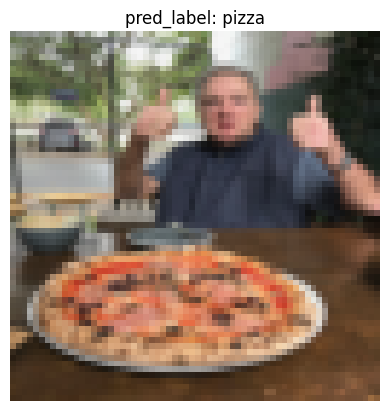

In [217]:
class_names = train_data.classes

model_1.eval()
with torch.inference_mode():
  pred_logits = model_1(img_transformed.unsqueeze(dim=0))
  pred_label = torch.argmax(torch.softmax(pred_logits, dim=1), dim=1)

plt.imshow(img_transformed.permute(1, 2, 0))
plt.title(f"pred_label: {class_names[pred_label]}")
plt.axis("off")